In [5]:
import feather
import scipy as sp
import numpy as np
import pandas as pd
import lightgbm as lgb

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.linear_model import Ridge
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, GroupKFold

import matplotlib.pyplot as plt
import seaborn as sns

def get_score(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def get_y():
    return pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv', usecols=[target]).values.flatten()
    
def run_model(X_train, y_train, X_valid, y_valid,
            categorical_features, numerical_features,
            predictors, maxvalue_dict, fold_id):
    
    model = Ridge()
    model.fit(X_train, y_train)
    
    # validation score
    y_pred_valid = model.predict(X_valid)

    # feature importances
    importances = pd.DataFrame()
    importances['feature'] = predictors
    importances['gain'] = model.coef_
    importances['fold'] = fold_id

    return y_pred_valid, importances
 
def plot_mean_feature_importances(feature_importances, max_num=50, importance_type='gain', path=None):
    mean_gain = feature_importances[[importance_type, 'feature']].groupby('feature').mean()
    feature_importances['mean_' + importance_type] = feature_importances['feature'].map(mean_gain[importance_type])

    if path is not None:
        data = feature_importances.sort_values('mean_'+importance_type, ascending=False).iloc[:max_num, :]
        plt.clf()
        plt.figure(figsize=(16, 8))
        sns.barplot(x=importance_type, y='feature', data=data)
        plt.tight_layout()
        plt.savefig(path)
    
    return feature_importances

def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -get_score(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [6]:
target = 'AdoptionSpeed'
len_train = 14993
len_test = 3948
    
    
# ===============
# Params
# ===============
seed = 777
n_splits = 5
np.random.seed(seed)

# feature engineering
n_components = 5
img_size = 256
batch_size = 256

# model
MODEL_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 63,
    'subsample': 0.9,
    'subsample_freq': 1,
    #'colsample_bytree': 0.6,
    'max_depth': 9,
    'max_bin': 127,
    'reg_alpha': 0.11,
    'reg_lambda': 0.01,
    'min_child_weight': 0.2,
    'min_child_samples': 20,
    'min_gain_to_split': 0.02,
    'min_data_in_bin': 3,
    'bin_construct_sample_cnt': 5000,
    'cat_l2': 10,
    'verbose': -1,
    'nthread': 16,
    'seed': 777,
}
FIT_PARAMS = {
    'num_boost_round': 5000,
    'early_stopping_rounds': 100,
    'verbose_eval': 10000,
}

# define
maxvalue_dict = {}
categorical_features = [
     'Breed1',
     'Breed2',
     'Color1',
     'Color2',
     'Color3',
     'Dewormed',
     'FurLength',
     'Gender',
     'Health',
     'MaturitySize',
     'State',
     'Sterilized',
     'Type',
     'Vaccinated',
     'Type_main_breed',
     'BreedName_main_breed',
     'Type_second_breed',
     'BreedName_second_breed',
]
numerical_features = []
text_features = ['Name', 'Description']
remove = ['index', 'seq_text', 'PetID', 'Name', 'Description', 'RescuerID', 'StateName', 'annots_top_desc']

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

train = feather.read_dataframe('X_train460.feather')
n_train = len(train)

categorical_features = list(set(categorical_features) - set(remove))
numerical_features = list(set(train.columns) - set(categorical_features + [target] + remove))
predictors = categorical_features + numerical_features
train = train.loc[:, ~train.columns.duplicated()]

for c in categorical_features:
    train[c] = LabelEncoder().fit_transform(train[c])
train.replace(np.inf, np.nan, inplace=True)
train.replace(-np.inf, np.nan, inplace=True)
train[numerical_features] = StandardScaler().fit_transform(train[numerical_features].rank())
train.fillna(0, inplace=True)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:771: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count


In [15]:
MODEL_PARAMS = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31, #no 15
    'subsample': 0.9,
    'subsample_freq': 1,
    #'colsample_bytree': 0.6,
    'max_depth': 9, #no 7
    'max_bin': 127, #no63, 255
    'reg_alpha': 0.5, #no 1.0
    'reg_lambda': 0.01, #no0.5
    'min_child_weight': 0.2, #no impact
    'min_child_samples': 10, #no 5
    'min_gain_to_split': 0.02,#no0.1, 0.01
    'min_data_in_bin': 3, #no10
    'bin_construct_sample_cnt': 5000, #no 3000, 7000
    'cat_l2': 10, #no
    'verbose': -1,
    'nthread': 16,
    'seed': 777,
}

0.36787092435072966
CPU times: user 1min 12s, sys: 48.5 s, total: 2min
Wall time: 27.1 s


<Figure size 432x288 with 0 Axes>

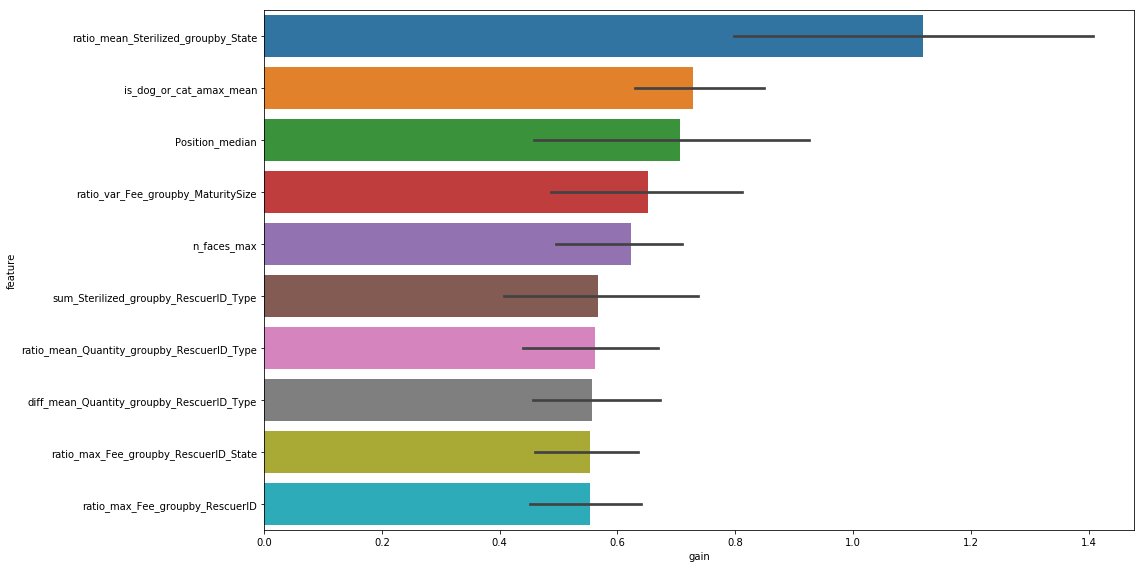

In [9]:
%%time
X = train.loc[:, predictors]
y =  feather.read_dataframe('../input/X_train.feather')["AdoptionSpeed"].values
rescuer_id = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv').loc[:, 'RescuerID'].iloc[:len_train]

feature_importances = pd.DataFrame()
y_pred = np.empty(len_train,)
y_test = []

#cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y)):
cv = GroupKFold(n_splits=n_splits)
for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=None, groups=rescuer_id)): 
    X_train = X.loc[train_index, :]
    X_valid = X.loc[valid_index, :]
    y_train = y[train_index]
    y_valid = y[valid_index]

    y_pred_valid, importances = run_model(X_train, y_train, X_valid, y_valid,
                     categorical_features, numerical_features,
                     predictors, maxvalue_dict, fold_id)
    y_pred[valid_index] = y_pred_valid.ravel()

    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

# plot
feature_importances = plot_mean_feature_importances(
                            feature_importances, 
                            max_num=50, 
                            importance_type='gain', 
                            path='gain_feature_importances.png')

optR = OptimizedRounder()
optR.fit(y_pred, y)
coefficients = optR.coefficients()
y_pred_opt = optR.predict(y_pred, coefficients)
score = get_score(y, y_pred_opt)
print(score)

In [11]:
importance_type="gain"
feature_importances[importance_type] = abs(feature_importances[importance_type])
mean_gain = feature_importances[[importance_type, 'feature']].groupby('feature').mean().reset_index()
data = mean_gain.sort_values(importance_type, ascending=False)
print(len(data))
data.head()

3784


,feature,gain
3551,ratio_mean_Sterilized_groupby_State,1.119154
3580,ratio_median_Quantity_groupby_Type_Breed1_Breed2,0.923258
2234,diff_median_Quantity_groupby_Type_Breed1_Breed2,0.774560
3263,is_dog_or_cat_amax_mean,0.728357
1876,Position_median,0.706498


In [23]:
list(data.feature.values)[:100]

['ratio_mean_Sterilized_groupby_State',
 'ratio_median_Quantity_groupby_Type_Breed1_Breed2',
 'diff_median_Quantity_groupby_Type_Breed1_Breed2',
 'is_dog_or_cat_amax_mean',
 'Position_median',
 'ratio_var_Fee_groupby_MaturitySize',
 'n_faces_max',
 'diff_min_Quantity_groupby_RescuerID_State',
 'diff_min_Quantity_groupby_RescuerID',
 'sum_Sterilized_groupby_RescuerID_Type',
 'ratio_mean_Quantity_groupby_RescuerID_Type',
 'diff_mean_Quantity_groupby_RescuerID_Type',
 'ratio_min_Sterilized_groupby_Type_Breed1',
 'ratio_max_Fee_groupby_RescuerID_State',
 'ratio_max_Fee_groupby_RescuerID',
 'ratio_min_Age_groupby_MaturitySize',
 'ratio_max_Fee_groupby_State',
 'ratio_min_Quantity_groupby_RescuerID_State',
 'ratio_min_Quantity_groupby_RescuerID',
 'n_text_annotations_mean',
 'ratio_var_Sterilized_groupby_State',
 'diff_min_Sterilized_groupby_RescuerID_State',
 'diff_min_Sterilized_groupby_RescuerID',
 'diff_mean_Quantity_groupby_Type_Breed1',
 'color_blue_score_sum_max',
 'Position_min',
 'd

In [18]:
train = feather.read_dataframe('X_train460.feather')
n_train = len(train)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[810]	valid's rmse: 1.03594


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[899]	valid's rmse: 1.05848


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[589]	valid's rmse: 1.04733


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[808]	valid's rmse: 1.05646


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[611]	valid's rmse: 1.06821
0.4303628964528613
CPU times: user 16min 53s, sys: 1.45 s, total: 16min 55s
Wall time: 1min 22s


<Figure size 432x288 with 0 Axes>

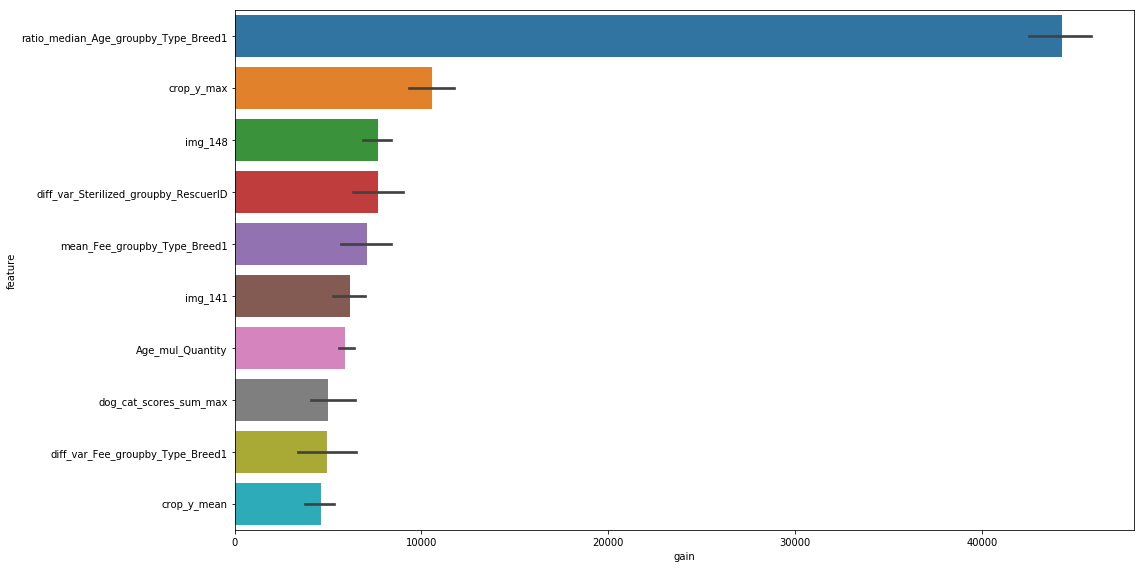

In [24]:
%%time

def run_model(X_train, y_train, X_valid, y_valid,
            categorical_features, numerical_features,
            predictors, maxvalue_dict, fold_id):
    train = lgb.Dataset(X_train, y_train, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    valid = lgb.Dataset(X_valid, y_valid, 
                        categorical_feature=categorical_features, 
                        feature_name=predictors)
    evals_result = {}
    model = lgb.train(
        MODEL_PARAMS,
        train,
        valid_sets=[valid],
        valid_names=['valid'],
        evals_result=evals_result,
        **FIT_PARAMS
    )
    
    # validation score
    y_pred_valid = model.predict(X_valid)

    # feature importances
    importances = pd.DataFrame()
    importances['feature'] = predictors
    importances['gain'] = model.feature_importance(importance_type='gain')
    importances['split'] = model.feature_importance(importance_type='split')
    importances['fold'] = fold_id

    return y_pred_valid, importances

n_feats =1000
predictors = list(data.feature[:n_feats])
categorical_features = list(set(categorical_features) - set(remove))
categorical_features = [c for c in categorical_features if c in predictors]
numerical_features = list(set(predictors) - set(categorical_features + [target] + remove))
#predictors = categorical_features + numerical_features

X = train.loc[:, predictors]
y =  feather.read_dataframe('../input/X_train.feather')["AdoptionSpeed"].values
rescuer_id = pd.read_csv('../input/petfinder-adoption-prediction/train/train.csv').loc[:, 'RescuerID'].iloc[:len_train]

feature_importances = pd.DataFrame()
y_pred = np.empty(len_train,)
y_test = []

#cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)
#for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y)):
cv = GroupKFold(n_splits=n_splits)
for fold_id, (train_index, valid_index) in enumerate(cv.split(range(len(X)), y=None, groups=rescuer_id)): 
    X_train = X.loc[train_index, :]
    X_valid = X.loc[valid_index, :]
    y_train = y[train_index]
    y_valid = y[valid_index]

    y_pred_valid, importances = run_model(X_train, y_train, X_valid, y_valid,
                     categorical_features, numerical_features,
                     predictors, maxvalue_dict, fold_id)
    y_pred[valid_index] = y_pred_valid.ravel()

    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

# plot
feature_importances = plot_mean_feature_importances(
                            feature_importances, 
                            max_num=50, 
                            importance_type='gain', 
                            path='gain_feature_importances.png')

optR = OptimizedRounder()
optR.fit(y_pred, y)
coefficients = optR.coefficients()
y_pred_opt = optR.predict(y_pred, coefficients)
score = get_score(y, y_pred_opt)
print(score)

In [ ]:
150-0.3874458533166226

all(3784)-0.449078003109212(5min46s)